# Feature extraction

This part of the course is about detecting features like edges, lines, circles, and blobs from images. Many biological objects (cells, bacteria, bacilli, etc.) can be approximated by simple shapes and detected this way. While deep learning approaches typically outperform the classical approaches presented here, they are still part of most image processing pipelines, and complement deep learning techniques either as pre-processing or post-processing.

Run the code making sure you understand the syntax. Complete the parts marked **TODO** either in the text or in the code.

Don't hesitate to re-use what you learned in previous notebooks (filtering, morphological operations etc) to improve your results!

## Setup

First, we need to import some packages so that their functions are available to us.

In [29]:
import os                       # operating system operations like file paths etc
import numpy as np              # multidimensional arrays, linear algebra
from skimage import morphology  # morphological operations
from skimage import io          # to load and save data
from skimage import color       # color conversion utilities
from skimage import segmentation
from skimage import exposure
from skimage.util import invert   # invert an image (if binary, black->white, white->black)
from skimage import img_as_ubyte # Convert an image to 8-bits
from skimage.filters import threshold_otsu # Otsu's thresholding method
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks, hough_line, hough_line_peaks



import matplotlib.pyplot as plt # plotting


path_to_images= './data'    # where the images are relative to this notebook. On Nuvolos, you may need to provide an absolute path

## Data loading and exploration

Let's start with our previous neuroblastoma image.

Image has shape (512, 640)


Text(0.5, 1.0, 'Original image')

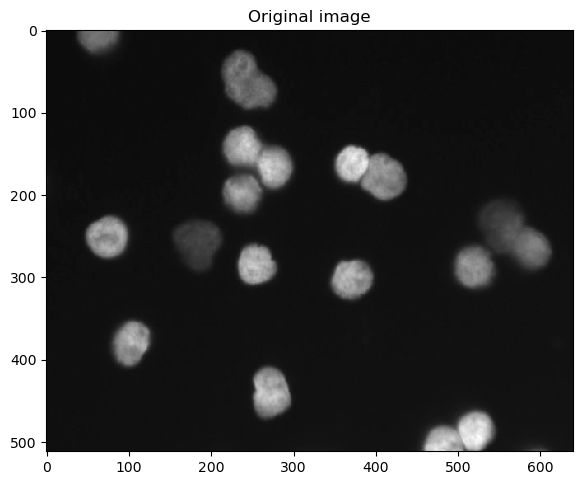

In [31]:
# Load and normalize the neuroblastoma image
image_file = os.path.join(path_to_images, 'neuroblastoma_5_orig_small.jpg')
img = io.imread(image_file)
img = img/np.max(img) # normalize the image to [0,1]
print(f'Image has shape {img.shape}')

# Display the image
plt.figure()
io.imshow(img)
plt.title('Original image')

## Edge detection

Edge detections allows us to find regions of the image with sharp contrast, that is where dark rapidly becomes bright and vice-versa. These edges may not correspond to human perception.

A commonly used algorithm is the Canny algorithm, open and read the documentation in scikit-image
- <https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny>


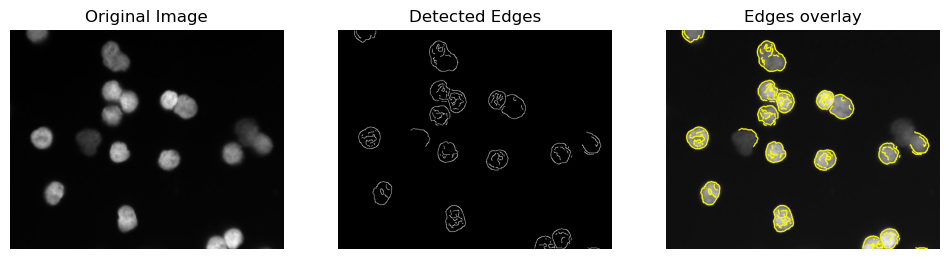

In [32]:
# Apply histogram equalization to improve contrast
#img = exposure.equalize_hist(img)

# Detect edges using Canny edge detector
edges = canny(img)

# create an overlay of the edges on the original image
edges_overlay = segmentation.mark_boundaries(img, np.array(edges,dtype=np.uint8), mode='thick')

# Display the original image and the detected edges side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Detected Edges')
axes[1].axis('off')
axes[2].imshow(edges_overlay)
axes[2].set_title('Edges overlay')
axes[2].axis('off')

plt.show()





## Hough transform

The Hough transform is a fast and efficient approach to detecting lines, circles, and ellipses.

### Hough transform for circles

Detected 10 circles


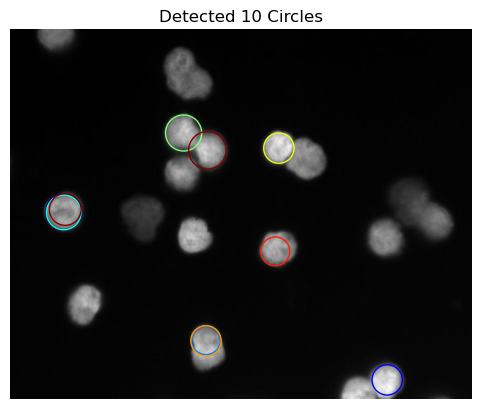

In [57]:

# Define the range of radii to search for circles
min_radius = 20
max_radius = 50

# Apply the Hough transform to detect circles
hough_radii = np.arange(min_radius, max_radius + 1)
hough_res = hough_circle(edges, hough_radii)

# Find the most prominent circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10)
n_circles=radii.shape[0]
print(f'Detected {n_circles} circles')


# Display the original image with detected circles in different colors
cm=plt.cm.jet # get a colormap
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

for i, (center_y, center_x, radius) in enumerate(zip(cy, cx, radii)):
    circle = plt.Circle((center_x, center_y), radius, color=cm(i/(n_circles-2)), fill=False)
    ax.add_patch(circle)

plt.title(f'Detected {n_circles} Circles')
plt.axis('off')
plt.show()


### Hough transform for lines

Here we are trying to approximately count the number of gram-positive bacilli from a gram staining image. Since the bacilli are linear, we can look for lines in the image using a Hough transform. 

Note that this approach is for didactic purposes, there are better methods to perform this kind of analysis.

We will use the scikit-image implementation. The two functions you need (read the docs!) are
- <https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line>
- <https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line_peaks>

Image has shape (308, 338)


Text(0.5, 1.0, 'Original image')

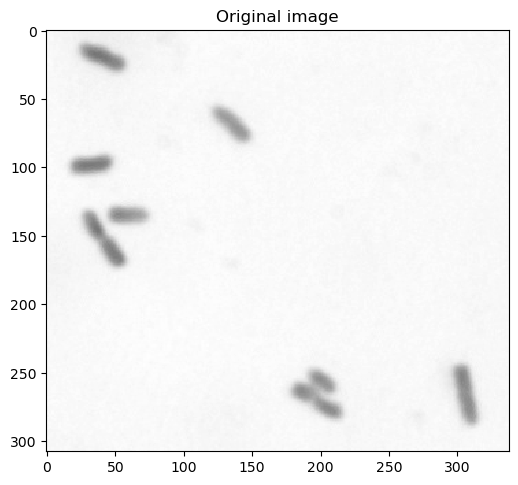

In [85]:
# Load and normalize the E.Coli image
image_file = os.path.join(path_to_images, 'gram_negative_bacilli_crop.png')
img = io.imread(image_file)
img = color.rgb2gray(img) # convert to grayscale
img = img/np.max(img) # normalize the image to [0,1]
print(f'Image has shape {img.shape}')

# Display the image
plt.figure()
io.imshow(img)

plt.title('Original image')

Found 10 lines


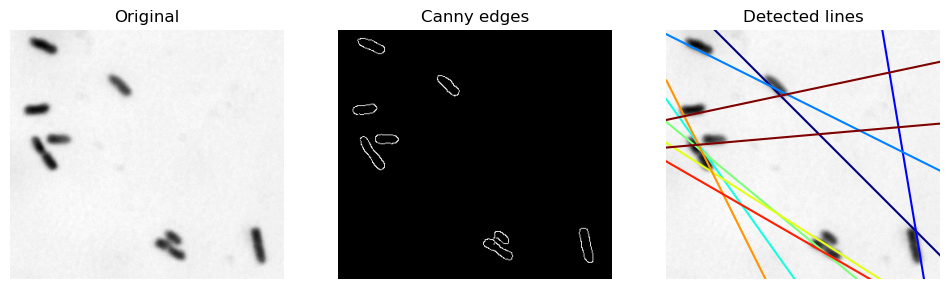

In [93]:
# example adapted from skimage doc


# First detect edges to make our life easier - Hough transform is sensitive to noise
edges=canny(img)

# Define the range of angles to search for lines. If we have a priori information about the orientation of the lines
# we are interested in, we could restrict the search range
search_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)

# Run the Hough transform
houghspace, houghangles, houghdistances = hough_line(edges, theta=search_angles)

# Find the most prominent lines
peaks = hough_line_peaks(houghspace, houghangles, houghdistances, min_distance=20,min_angle=20)
n_peaks=len(peaks[0])
print(f'Found {n_peaks} lines')

# Overlay the detected lines on the image
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Canny edges')
ax[1].set_axis_off()

ax[2].imshow(img,cmap='gray')
ax[2].set_xlim((0,img.shape[1]))
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for i, (_, angle, dist) in enumerate(zip(*peaks)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi / 2), color=cm(i/(n_peaks-2)))

plt.show()


Your goal is to get a count of the bacilli. The true value is probably 8. Here we approximate the number of bacilli found by the number of lines detected. Again, this is not a robust approach in real life.


**TODO** Play with the `min_distance` and `min_angle` of the `hough_line_peaks` function. Can you improve upon the initial setting of 20 and 20? 

**TODO** What is the impact of the resolution of the search angles?

**TODO** The two bacilli in the south-west corner of the image have a thinner midsection. Can you run morphological operations to try and fill them ? Does that improve or worsen the Hough transform results?

## Second order approaches

### Laplacian of Gaussian (LoG)

In [52]:
cm=plt.cm.jet
print(cm(4/5))

(1.0, 0.40740740740740755, 0.0, 1.0)


Detected 13 blobs


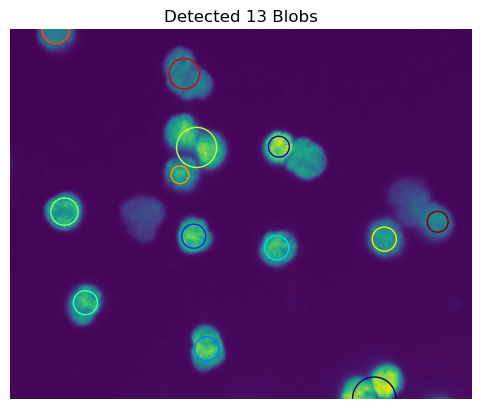

In [59]:
from skimage.feature import blob_log

# Define the range of blob sizes to detect
min_sigma = 10
max_sigma = 30

# Perform blob detection using LoG
blobs = blob_log(img, min_sigma=min_sigma, max_sigma=max_sigma)
n_blobs = blobs.shape[0]
print(f'Detected {n_blobs} blobs')

# Display the detected blobs
cm=plt.cm.jet # get a colormap
fig, ax = plt.subplots()
ax.imshow(img)

for i, blob in enumerate(blobs):
    y, x, radius = blob
    circle = plt.Circle((x, y), radius, color=cm(i/(n_blobs-1)), fill=False)
    ax.add_patch(circle)

plt.title(f'Detected {n_blobs} Blobs')
plt.axis('off')
plt.show()
